# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


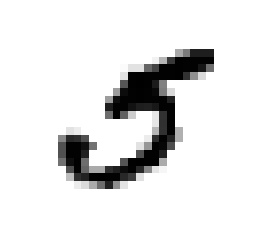

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = 'nearest')
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 3.2 Binary classifier

In [8]:
y_train_5 = (y_train == 5) # 5 is True, else False
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 Performance measurement 

### 3.3.1 Cross Validation Score

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfold.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95275
0.96135
0.9547


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.95275, 0.96135, 0.9547 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91115, 0.90885, 0.90895])

### 3.3.2 Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54007,   572],
       [ 2052,  3369]])

### 3.3.3 Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.854859172798782

In [18]:
recall_score(y_train_5, y_train_pred)

0.6214720531267294

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7197180089724418

### 3.3.4 Precision/Recall Trade-off

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([83029.72562377])

In [21]:
threshold = 30000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-1836078.3145566 ,  -278844.64672745,  -700385.99767943, ...,
        -768882.19547617,  -267659.70183194,  -326941.78781246])

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

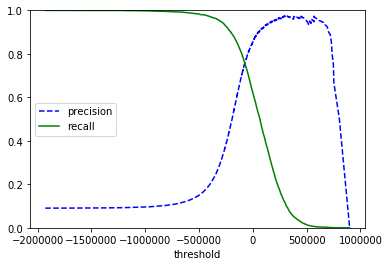

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

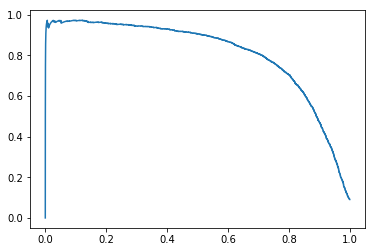

In [25]:
plt.plot(recalls[:-1], precisions[:-1])
plt.show()

In [26]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9092776446422458

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.48994650433499354

### 3.3.5 ROC Curve

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

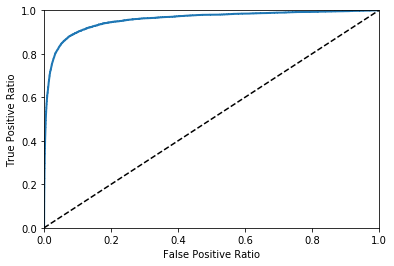

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9571773959764913

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

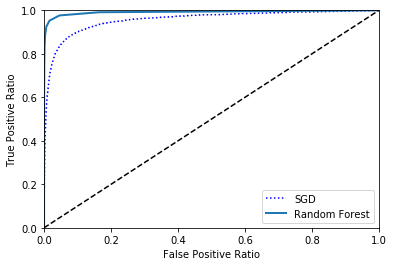

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9918593316662857

# 3.4 Mulitclass classification

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  78672.13957137, -403391.26796445, -296574.93813562,
        -229918.2936099 , -407433.34749077,   83029.72562377,
        -835803.85779503, -451961.52687962, -592928.15285103,
        -548304.72682561]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
sgd_clf.classes_[5]

5.0

In [40]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0.2, 0. , 0. , 0.1, 0. , 0.7, 0. , 0. , 0. , 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8669766 , 0.88584429, 0.88373256])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91116777, 0.90959548, 0.9126869 ])

# 3.5 Error Analysis

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5746,    2,   22,    9,    9,   40,   43,    7,   39,    6],
       [   2, 6499,   38,   22,    6,   42,    6,   10,  104,   13],
       [  62,   34, 5348,   94,   80,   26,   88,   55,  153,   18],
       [  50,   45,  129, 5339,    2,  243,   34,   61,  133,   95],
       [  26,   30,   31,    7, 5373,   13,   50,   30,   94,  188],
       [  75,   46,   32,  196,   72, 4616,  103,   30,  173,   78],
       [  36,   22,   39,    2,   38,   86, 5643,    8,   44,    0],
       [  27,   27,   69,   31,   61,   11,    5, 5800,   17,  217],
       [  53,  161,   74,  140,   17,  164,   52,   29, 5031,  130],
       [  43,   37,   27,   83,  160,   39,    2,  196,   88, 5274]])

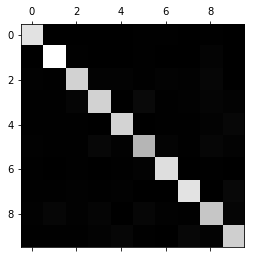

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.70116495e-01, 3.37666723e-04, 3.71433395e-03, 1.51950025e-03,
        1.51950025e-03, 6.75333446e-03, 7.25983454e-03, 1.18183353e-03,
        6.58450110e-03, 1.01300017e-03],
       [2.96647879e-04, 9.63957283e-01, 5.63630970e-03, 3.26312667e-03,
        8.89943637e-04, 6.22960546e-03, 8.89943637e-04, 1.48323939e-03,
        1.54256897e-02, 1.92821121e-03],
       [1.04061766e-02, 5.70661296e-03, 8.97616650e-01, 1.57771064e-02,
        1.34273246e-02, 4.36388050e-03, 1.47700571e-02, 9.23128567e-03,
        2.56797583e-02, 3.02114804e-03],
       [8.15527646e-03, 7.33974882e-03, 2.10406133e-02, 8.70820421e-01,
        3.26211059e-04, 3.96346436e-02, 5.54558800e-03, 9.94943729e-03,
        2.16930354e-02, 1.54950253e-02],
       [4.45053064e-03, 5.13522766e-03, 5.30640192e-03, 1.19821979e-03,
        9.19719274e-01, 2.22526532e-03, 8.55871277e-03, 5.13522766e-03,
        1.60903800e-02, 3.21807600e-02],
       [1.38350858e-02, 8.48551928e-03, 5.90296993e-03, 3.61556908e-02,
   

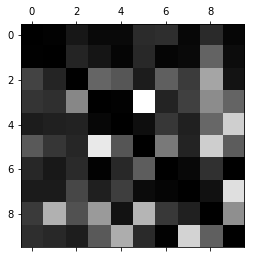

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [54]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

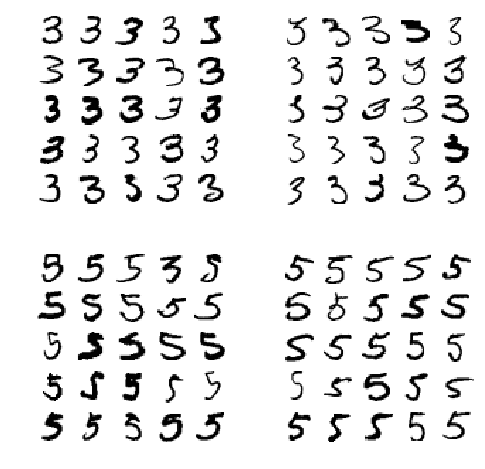

In [55]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 3.6 Multilabel Classification

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 3.7 Multioutput Classification

In [78]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

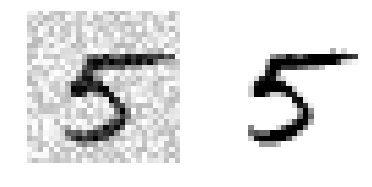

In [79]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

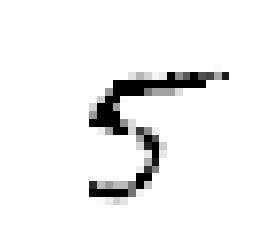

In [80]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)